In [3]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import matplotlib.patches as patches
from pylatex import Document, Section, Subsection, Math, NoEscape, Package, NewPage
from IPython.display import display, Math, Latex, HTML, Markdown


In [4]:
# Parameters
M_u = 100.0 # k-ft

# Material Properties
f_c = 6.0   # ksi
f_y = 60.0  # ksi

# Section Geometry
b     = 12.0
h     = 18.0
d     = h - 2.0
d_p   = 2.0
rebar = 8

# render toggles
render_nb  = True
create_pdf = False

# I. Design Parameters

## 1. Loads

In [5]:
load_s = '\\begin{align*} M_u = %s \\text{ k-ft}\\end{align*}'
# add to display
if render_nb == True:
    display(Latex(load_s % (M_u)))

<IPython.core.display.Latex object>

## 2. Properties

In [6]:
# Concrete
epsilon_c = 0.003 # strain limit
# Set beta (based on concrete strength, f_c)
if f_c <= 4:
    beta = 0.85
else:
    beta = round(max(0.65, 0.85 - 0.05 * (f_c - 4.)), 2)

concrete_array = np.array([f_c, epsilon_c, beta])
concrete_df = pd.DataFrame(columns=['$f\'_c\\text{ (ksi)}$', '$\\epsilon_c$', '$\\beta$'])
concrete_df.loc[0] =[f_c, epsilon_c, beta]

# Steel
f_y = 60 # ksi
E_s = 29000. # ksi
epsilon_y = round(f_y / E_s, 3)

steel_array = np.array([f_y, epsilon_c, E_s])
steel_df = pd.DataFrame(columns=['$f_y\\text{ (ksi)}$', '$\epsilon_y$', '$E_s\\text{ (ksi)}$'])
steel_df.loc[0] =[f_y, epsilon_y, E_s]

# Add properties to report as tables
d1 = dict(selector="th", props=[('text-align', 'center'), ('font-size', '11pt')])
d2 = dict(selector="td", props=[("text-align", "center"), ('font-size', '11pt')])
d3 = dict(selector="th:first-child", props=[('display', 'none')])

### Concrete Properties

In [7]:
concrete_df.style.set_properties(**{'width':'5em', 'text-align':'center'}).set_table_styles([d1,d2, d3])

,$f'_c\text{ (ksi)}$,$\epsilon_c$,$\beta$
0,6,0.003,0.75


### Steel Properties

In [8]:
steel_df.style.set_properties(**{'width':'5em', 'text-align':'center'}).set_table_styles([d1,d2, d3])

,$f_y\text{ (ksi)}$,$\epsilon_y$,$E_s\text{ (ksi)}$
0,60,0.002,29000


### Section Properties

In [9]:
prop_array = np.array([b, h, d])
prop_df = pd.DataFrame(columns=['b (in)', 'h (in)', 'd (in)'])
prop_df.loc[0] = prop_array

prop_df.style.set_properties(**{'width':'5em', 'text-align':'center'}).set_table_styles([d1,d2, d3])

,b (in),h (in),d (in)
0,12,18,16


## 4. Calculate Balanced Reinforcement Ratio $\rho_b$ and $x_{lim}$

In [10]:
xi_b = epsilon_c / (epsilon_c + epsilon_y)
rho_b = 0.85 * beta * (f_c / f_y) * xi_b

xi_lim = epsilon_c / (epsilon_c + 0.005)
rho_lim = 0.85 * beta * (f_c / f_y) * xi_lim
x_lim = xi_lim * d

### Balanced Reinforcement Ratio

In [11]:
pb_s = (r'\begin{align*}' +
        r'\xi_{b} &= \frac{\epsilon_c}{\epsilon_c + \epsilon_y} =' +
        r'\frac{%s}{%s + %s} = %s \\\\ '+
        '\\rho_{b} &= 0.85 \\cdot \\beta \\frac{f\'_c}{f_y} \\cdot \\xi_b'+
        r'= 0.85 \cdot %s \frac{%s \text{ ksi}}{%s \text{ ksi}} \cdot %s = %s '+
        r'\end{align*}')
pb_s_i = (epsilon_c, epsilon_c, epsilon_y, xi_b, beta, f_c, f_y, xi_b, rho_b)
if render_nb == True:
    display(Latex(pb_s % pb_s_i))


<IPython.core.display.Latex object>

### Tension Controlled Section

In [12]:
pb_lim_s = (r'\begin{align*} '+
            r'\xi_{lim} &= \frac{\epsilon_c}{\epsilon_c + 0.005} = '+
            r'\frac{%s}{%s + 0.005} = %s \\\\ ' +
            '\\rho_{lim} &= 0.85 \\cdot \\beta \\frac{f\'_c}{f_y} \\cdot \\xi_{lim} \\\\ '+
            r'\rho_{lim} &= 0.85 \cdot %s \frac{%s \text{ ksi}}{%s \text{ ksi}} \cdot %s = %s \\\\ '+
            r'x_{lim} &= \xi_{lim} \cdot d = %s \cdot %s \text{ in} = %s \text{ in}'+
            r'\end{align*}')
pb_lim_i = (epsilon_c, epsilon_c, xi_lim, beta, f_c, f_y, xi_lim, rho_lim, xi_lim, d, x_lim)
if render_nb == True:
    display(Latex(pb_lim_s % pb_lim_i))


<IPython.core.display.Latex object>

## 5. Determine Required Reinforcement

In [13]:
phi = 0.9 

M_u_lim = phi * 0.85* f_c * beta * b * x_lim * (d - beta * x_lim / 2.) * 1 / 12.
if M_u_lim >= M_u:
    x_na  = d / beta * (1 - (1 - M_u * 12. / (0.425 * phi * f_c * b * d ** 2.)) ** 0.5)
else:
    x_na  = x_lim

epsilon_s   = (d - x_na) * epsilon_c / x_na
epsilon_s_p = (d_p - x_na)* epsilon_c / x_na

# determine reinforcement stresses
if epsilon_s > epsilon_y:
    sigma_s = f_y
else:
    epsilon_s * E_s

if epsilon_s_p > epsilon_y:
    sigma_s_p = f_y
elif epsilon_s_p > 0:
    sigma_s_p = epsilon_s_p * E_s
elif epsilon_s_p < -epsilon_y:
    sigma_s_p = -f_y
else:
    sigma_s_p = epsilon_s_p * E_s
    
# determine reinforcement areas
if M_u_lim >= M_u:
    A_s_p = 0.0
else:
    A_s_p = (phi * 0.85 * f_c * beta * x_na * (d - beta * x_na / 2) * b - M_u * 12) \
            / (phi * sigma_s_p * (d - d_p))
A_s   = (0.85 * f_c * beta * x_na * b - A_s_p * sigma_s_p) / sigma_s    

#### Neutral Axis Location

In [14]:
if M_u_lim >= M_u:
    x_na_s = (r'\begin{align*}'+
              r'x_{na} &=\frac{d}{\beta} \cdot\left(1 - ' +
              '\\left(1 - \\frac{M_u}{(0.5 \\cdot 0.85 \\phi f\'_c b d^2)}\\right)^2\\right) \\\\' +
              r'x_{na} &=\frac{%s \text{ in}}{%s} \cdot\left(1 - ' +
              r'\left(1 - \frac{%s \text{ k-in}}{(0.5 \cdot 0.85 (%s)(%s\text{ ksi})(%s\text{ in})(%s \text{ in})^2)}\right)^2\right) \\\\ '+
              r'x_{na} &= %s \text{ in} \end{align*}')
    x_na_i = (d, beta, M_u*12, phi, f_c, b, d, round(x_na,2))
else:
    x_na_s = (r'\begin{align*} ' +
                r'x_{na} &= x_{lim} = %s'
                r'\end{align*}')
    x_na_i = round(x_na, 2)
    
if render_nb == True:
    display(Latex(x_na_s % x_na_i))
    

<IPython.core.display.Latex object>

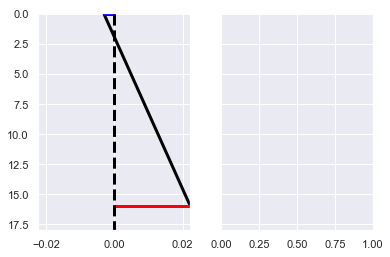

In [15]:
seaborn.set()
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
x = [-epsilon_c, epsilon_s]
y = [0, -d]
s_x = [0, epsilon_s]
s_y = [-d, -d]
c_x = [-epsilon_c, 0]
c_y = [0, 0]
ax_x = [0, 0]
ax_y = [0, -h]
ax1.plot(x, y, color='black', linewidth=3)
ax1.plot(s_x,s_y, color='red', linewidth=3)
ax1.plot(c_x,c_y, color='blue', linewidth=3)
ax1.plot(ax_x, ax_y, color='black', linewidth=3, linestyle='dashed')
ax1.set_ylim(-h, 0.1)
ax1.set_xlim(-epsilon_s, epsilon_s)
ax1.set_yticklabels([str(abs(y)) for y in ax1.get_yticks()])

left, width = - b / 2., b
bottom, height = -h, h
right = left + width
top = bottom + height
p = patches.Rectangle((left, bottom), width, height, fill=False)
ax2.add_patch(p)
plt.show()

#### Maximum Strength of Single Reinforced Section

In [16]:
M_u_s = (r'\begin{align*}' +
        'M_{u, lim} &= \phi \cdot 0.85 \cdot f\'_c \\beta \\text{ b} x_{lim}' +
        r'\left(\text{d} - \beta \frac{x_{lim}}{2}\right) \\\\' +
        r'M_{u, lim} &= %s \cdot 0.85 \cdot (%s \text{ksi})(%s)(%s \text{ in})' +
        r'(%s \text{ in})\left(%s \text{ in} - %s \frac{%s \text{ in}}{2}\right) \cdot \frac{12 \text{ in}}{\text{ft}}\\\\' +
        r'M_{u, lim} &= %s \text { k-ft}'
        '\end{align*}')
M_u_i = (phi, f_c, beta, b, x_lim, d, beta, x_lim, round(M_u_lim, 0))
if render_nb == True:
    display(Latex(M_u_s % M_u_i))


<IPython.core.display.Latex object>

#### Required Reinforcement

In [17]:
if render_nb == True:
    if M_u <= M_u_lim:
        display(Latex('$M_u \leq M_{u,lim}$'))
        display(Markdown('Positive Reinforcement Required'))
        A_s_str = (r'\begin{align*}' +
                   'A_s &= \\frac{0.85 f\'_c \\beta x_{na} b}{\\sigma_s} =' +
                   r'\frac{0.85 (%s \text{ ksi}) %s (%s  \text{ in})(%s \text{ in})}{(%s \text{ ksi})} \\\\' +
                   r'A_s &= %s \text{ in}^2' +
                   r'\end{align*}')
        A_s_i = (f_c, beta, round(x_na, 2), b, sigma_s, round(A_s, 2))
    else:
        display(Latex('$M_u \geq M_{u,lim}$'))
        display(Markdown('Positive and Negative Reinforcement Required'))
        A_s_p_str = (r'\begin{align*}' +
                     'A\'_s &= \\frac{\\phi 0.85 f_c \\beta x_{na} '+
                     r'\left(d - \beta \frac{x_{na}}{2}\right) b - M_u}' +
                     '{\\phi \\sigma\'_s (d - d\')} \\\\' +
                     'A\'_s &= \\frac{(%s)(0.85)(%s \\text{ ksi})(%s)(%s \\text{ in})'+
                     r'\left(%s \text{ in} - %s \frac{%s \text{ in}}{2}\right)(%s \text{ in}) - %s \text{ k-ft}\frac{12 \text{ in}}{\text{ft}}}' +
                     r'{%s (%s \text{ ksi}) (%s \text{ in} - %s \text{ in})} = %s \text{ in}^2' +
                     r'\end{align*}')
        A_s_p_i = (phi, f_c, beta, x_na, d, beta, x_na, b, M_u, phi, round(sigma_s_p, 2), d, d_p, round(A_s_p,2))
        A_s_str = (r'\begin{align*}' +
                   r'A_s &= \frac{0.85 f_c \beta x_{na} b}{\sigma_s} =' +
                   r'\frac{0.85 (%s \text{ ksi}) %s (%s  \text{ in})(%s \text{ in})}{(%s \text{ ksi})} \\\\' +
                   r'A_s &= %s \text{ in}^2' +
                   r'\end{align*}')
        A_s_i = (f_c, beta, round(x_na, 2), b, sigma_s, round(A_s, 2))
        display(Latex(A_s_p_str % A_s_p_i))
display(Latex(A_s_str % A_s_i))


<IPython.core.display.Latex object>

Positive Reinforcement Required

<IPython.core.display.Latex object>

In [18]:
bar_sizes = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 18])
bar_areas = np.around((bar_sizes / 8.) ** 2.0 * np.pi  / 4, 2)
num_pos_bars = np.ceil(A_s / bar_areas)
num_neg_bars = np.ceil(A_s_p / bar_areas)
space_pos_reinf = np.around(b / num_pos_bars, 2)
if A_s_p == 0:
    space_neg_reinf = 0.0 * num_neg_bars
else:
    space_neg_reinf = np.around(b / num_neg_bars, 2)

reinf_array = np.array([bar_sizes, bar_areas, num_pos_bars, num_neg_bars,
               space_pos_reinf, space_neg_reinf])
reinf_array = np.transpose(reinf_array)

reinf_df = pd.DataFrame(reinf_array, columns=['Bar No.', '$A_b({\\text{ in}}^2)$', 
                                              'No. Pos. Bars',
                                              'No. Neg. Bars',
                                              'Pos. Bar Spacing (in)',
                                              'Neg. Bar Spacing (in)'])
reinf_df.style.set_properties(**{'text-align':'center'}).set_table_styles([d1,d2, d3])

,Bar No.,$A_b({\text{ in}}^2)$,No. Pos. Bars,No. Neg. Bars,Pos. Bar Spacing (in),Neg. Bar Spacing (in)
0,3,0.11,14,0,0.86,0
1,4,0.2,8,0,1.5,0
2,5,0.31,5,0,2.4,0
3,6,0.44,4,0,3,0
4,7,0.6,3,0,4,0
5,8,0.79,2,0,6,0
6,9,0.99,2,0,6,0
7,10,1.23,2,0,6,0
8,11,1.48,1,0,12,0
9,14,2.41,1,0,12,0


## 6.  Generate Report

In [19]:
from codecs import decode

# Initialize document
doc = Document()
doc.packages.append(Package('amsmath'))
doc.packages.append(Package('booktabs'))
doc.packages.append(Package('caption'))
doc.packages.append(NoEscape('\\captionsetup{labelformat=empty}'))
section = Section('Design Parameters')

# add to report
subsection = Subsection('Design Load')
subsection.append(NoEscape(str.replace(load_s, "\\\\", "\\") % (M_u)))
section.append(subsection)
subsection = Subsection('Design Parameters')
cdf = concrete_df.to_latex(escape=False, index=False, column_format='ccc')
sdf = steel_df.to_latex(escape=False, index=False, column_format='ccc')
pdf = prop_df.to_latex(escape=False, index=False, column_format='ccc')
subsection.append(NoEscape('\\begin{center}\n\\captionof{table}{Steel Properties}'))
subsection.append(NoEscape(sdf))
subsection.append(NoEscape('\\end{center}'))
subsection.append(NoEscape('\\begin{center}\n\\captionof{table}{Concrete Properties}'))
subsection.append(NoEscape(cdf))
subsection.append(NoEscape('\\end{center}'))
subsection.append(NoEscape('\\begin{center}\n\\captionof{table}{Section Properties}'))
subsection.append(NoEscape(pdf))
subsection.append(NoEscape('\\end{center}'))
section.append(subsection)
doc.append(section)

section = Section('Calculate Balanced Reinforcement Ratio')
subsection = Subsection('Balanced Reinforcement Ratio')
subsection.append(NoEscape(pb_s % pb_s_i))
section.append(subsection)
subsection = Subsection('Ensure Tension Controlled Section')
subsection.append(NoEscape(pb_lim_s % pb_lim_i))
section.append(subsection)
doc.append(section)

doc.append(NewPage())
section = Section('Determine Required Reinforcement')
subsection = Subsection('Find Neutral Axis Location')
subsection.append(NoEscape(x_na_s % x_na_i))
subsection = Subsection('Find Maximum Strength of Singly Reinforced Section')
subsection.append(NoEscape(M_u_s % M_u_i))
section.append(subsection)
subsection = Subsection('Calculate Required Reinforcement')
if M_u <= M_u_lim:
    subsection.append(NoEscape('$M_u \leq M_{u,lim} \\Rightarrow$ Positive Reinforcement Required'))
    #subsection.append('')
    subsection.append(NoEscape(A_s_str % A_s_i))
else:
    subsection.append(NoEscape('$M_u \geq M_{u,lim} \\Rightarrow$ Positive and Negative Reinforcement Required \n'))
    subsection.append(NoEscape('\n \\textbf{Positive Reinforcement}, $A_s$'))   
    subsection.append(NoEscape(A_s_str % A_s_i))
    subsection.append(NoEscape('\n \\textbf{Negative Reinforcement}, $A\'_s$'))
    subsection.append(NoEscape(A_s_p_str % A_s_p_i))
reinfdf = reinf_df.to_latex(escape=False, index=False, column_format='cccccc')
subsection.append(NoEscape('\\begin{center}\n\\captionof{table}{Required Reinforcement by Bar Size}'))
subsection.append(NoEscape(reinfdf))
subsection.append(NoEscape('\\end{center}'))
section.append(subsection)
doc.append(section)

doc.generate_pdf('beam_ex2', clean_tex=False)